This jupyter-notebook has be created with 'jupytext'.

Use this [Link](https://colab.research.google.com/github/magnumnp/magnumnp_demos/blob/main/sp_DMI.ipynb) to directly open the Notebook in Google Colab.

## Install magnum.np and fetch reference data (required for Colab)

In [1]:
!pip install -q triton magnumnp
from os import path
if not path.isdir("ref"):
    !mkdir ref
    !wget -P ref https://gitlab.com/magnum.np/magnum.np/raw/main/demos/sp_DMI/ref/m.dat &> /dev/null
from magnumnp import *

2024-11-02 23:07:56  magnum.np:INFO magnum.np 2.0.1


# DMI Standard Problem

## Run Simulation

In [2]:
from magnumnp import *
import torch
import numpy as np
import pathlib

set_log_level(25) # show info_green, but hide info_blue
Timer.enable()
try:
    this_dir = pathlib.Path(__file__).resolve().parent
except:
    this_dir = pathlib.Path().resolve()

n  = (100, 1, 1)
dx = (1e-9, 1e-9, 1e-9)
origin = (-n[0]*dx[0]/2., -n[1]*dx[1]/2., -n[2]*dx[2]/2.,)

mesh = Mesh(n, dx, origin)
state = State(mesh)
state.material.set({
    "alpha": 1.,
    "A": 13e-12,
    "Ms": 800e3,
    "Di": -3e-3,
    "Ku": 0.4e6,
    })
state.material['Ku_axis'] = state.Constant([0,0,1])
x, y, z = mesh.SpatialCoordinate()

state.write_vtk(state.material, "data/material")

state.m = state.Constant([-0.1, 0.0, 0.9])
normalize(state.m)

exchange = ExchangeField()
aniso    = UniaxialAnisotropyField()
dmi      = InterfaceDMIField()

minimizer = MinimizerBB([exchange, aniso, dmi])
minimizer.minimize(state)
np.savetxt(this_dir / "data" / "m0_magnumnp.dat", torch.concat((x[:,0,0,None], state.m[:,0,0,:]), axis=1).cpu().numpy())

Timer.print_report()

2024-11-02 23:07:56  magnum.np:INFO [State] running on device: cpu (dtype = float64)


2024-11-02 23:07:56  magnum.np:INFO [Mesh] 100x1x1 (dx= 1e-09 x 1e-09 x 1e-09)



TIMER REPORT
Operation                        No of calls    Avg time [ms]    Total time [s]
-----------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                       1       14296.1          14.2961
    ExchangeField.h                      128          56.4474        7.22526
    UniaxialAnisotropyField.h            128          20.9332        2.67945
    InterfaceDMIField.h                  128          33.7066        4.31444
-----------------------------  -------------  ---------------  ----------------
Total                                                               14.3056
Missing                                                              0.00940915



## Plot Results

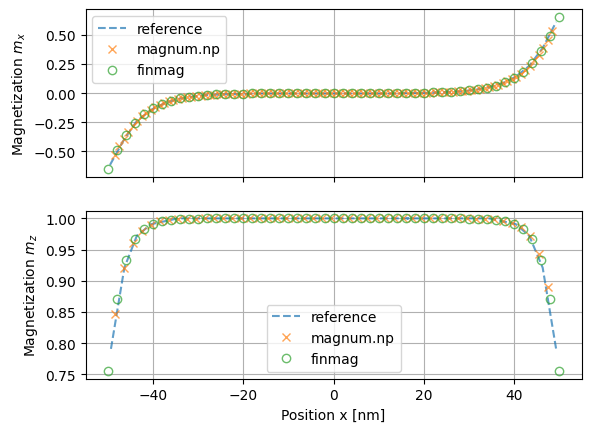

In [3]:
import numpy as np
import matplotlib.pyplot as plt

magnumnp = np.loadtxt("data/m0_magnumnp.dat")
#magnumpi = np.loadtxt("data/m0_magnumpi.dat")

finmag = np.loadtxt("ref/m0_finmag.dat")
ref_x = np.loadtxt("ref/interfaceDMI_mx.dat")
ref_z = np.loadtxt("ref/interfaceDMI_mz.dat")

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True)
ax1.plot(ref_x[:,0], ref_x[:,1], "--", color=cycle[0], alpha = 0.7, label = r"reference")
ax1.plot(magnumnp[1:-1,0]*1e9, magnumnp[1:-1,1], "x", color=cycle[1], alpha = 0.7, label = "magnum.np")
ax1.plot(finmag[::2,0]-50., finmag[::2,1], "o", mfc='none', color=cycle[2], alpha = 0.7,  label = "finmag")
ax1.set_ylabel("Magnetization $m_x$")

ax2.plot(ref_z[:, 0], ref_z[:,1], "--", color=cycle[0], alpha = 0.7, label = r"reference")
ax2.plot(magnumnp[1:-1:2,0]*1e9, magnumnp[1:-1:2,3], "x", color=cycle[1], alpha = 0.7, label = "magnum.np")
ax2.plot(finmag[::2,0]-50., finmag[::2,3], "o", mfc='none', color=cycle[2], alpha = 0.7, label = "finmag")
ax2.set_ylabel("Magnetization $m_z$")

for ax in ax1, ax2:
    ax.legend()
    ax.grid()
ax2.set_xlabel("Position x [nm]")
fig.savefig("data/results.png")